# Pride and Prejudice RAG

In [1]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq
import gradio
import re
import json

/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from the text file and cleaning it

In [2]:
import re

# Lade den Text
with open("data/prideandprejudiceplain.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

def clean_pride_and_prejudice(text):
    # Entferne Header (alles bis CHAPTER I.)
    text = re.sub(r"Title:.*?CHAPTER I\.\]", "", text, flags=re.DOTALL)

    # Entferne alle Illustrationen (Copyright, Zeichnungen etc.)
    text = re.sub(r"\[Illustration:.*?\]", "", text, flags=re.DOTALL)
    text = re.sub(r"\[Illustration\]", "", text)
    text = re.sub(r"\[_Copyright.*?\]", "", text)
    text = re.sub(r"\[|\]", "", text)

    # Entferne NIND-Tags
    text = re.sub(r"/\* NIND.*?\*/", "", text)

    # Entferne sonstige ASCII-Dekorationen
    text = re.sub(r"\[.*?\]", "", text)

    # Mehrfache Leerzeilen auf eine reduzieren
    text = re.sub(r"\n{2,}", "\n\n", text)

    # Trim
    text = text.strip()

    return text

# Bereinige den Text
clean_text = clean_pride_and_prejudice(raw_text)

# Vorschau
print(clean_text[:200])

# Speichere bereinigte Datei
with open("pride_and_prejudice_cleaned.txt", "w", encoding="utf-8") as f:
    f.write(clean_text)


Title: Pride and Prejudice

Author: Jane Austen

Release date: June 1, 1998 eBook #1342
                Most recently updated: October 29, 2024

Chapter I.

It is a truth universally acknowledged, tha


## 2. Splitting the Text into Chunks

In [3]:
# Create a splitter:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200,  separators=["\n\n", "\n", ".", "!", "?", ";", ":"])
# Split the extracted text into manageable chunks
chunks = splitter.split_text(clean_text)

In [4]:
print(f"Total chunks: {len(chunks)}")

print("Preview of a chunk:", chunks[90][:1000])

Total chunks: 964
Preview of a chunk: “I cannot see that London has any great advantage over the country, for
my part, except the shops and public places. The country is a vast deal
pleasanter, is not it, Mr. Bingley?”

“When I am in the country,” he replied, “I never wish to leave it; and
when I am in town, it is pretty much the same. They have each their
advantages, and I can be equally happy in either.”

“Ay, that is because you have the right disposition. But that
gentleman,” looking at Darcy, “seemed to think the country was nothing
at all.”

“Indeed, mamma, you are mistaken,” said Elizabeth, blushing for her
mother. “You quite mistook Mr. Darcy. He only meant that there was not
such a variety of people to be met with in the country as in town, which
you must acknowledge to be true.”

“Certainly, my dear, nobody said there were; but as to not meeting with
many people in this neighbourhood, I believe there are few
neighbourhoods larger. I know we dine with four-and-twenty families.

## 3. Tokenizing the Text 

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=40, tokens_per_chunk=256, model_name="sentence-transformers/all-mpnet-base-v2")

In [6]:

token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")

#bsp
print(token_split_texts[62])



Total chunks: 970
“ well, jane, who is it from? what is it about? what does he say? well, jane, make haste and tell us ; make haste, my love. ” “ it is from miss bingley, ” said jane, and then read it aloud. “ if you are not so compassionate as to dine to - day with louisa and me, we shall be in danger of hating each other for the rest of our lives ; for a whole day ’ s _ tete - a - tete _ between two women can never end without a quarrel. come as soon as you can on the receipt of this. my brother and the gentlemen are to dine with the officers. yours ever, “ caroline bingley. ” “ with the officers! ” cried lydia : “ i wonder my aunt did not tell us of _ that _. ” “ dining out, ” said mrs. bennet ; “ that is very unlucky. ” “ can i have the carriage? ” said jane. “ no, my dear, you had better go on horseback, because it seems likely to rain ; and then you must stay all night. ” “ that would be a good scheme, ” said elizabeth, “ if you were sure that they would not offer to


## Embedding


In [7]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', 'title', ':', 'pride', 'and', 'prejudice', 'author', ':', 'jane', 'austen', 'release', 'date', ':', 'june', '1', ',', '1998', 'ebook', '#', '134', '##2', 'most', 'recently', 'updated', ':', 'october', '29', ',', '202', '##4', 'chapter', 'i', '.', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', ',', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '.', 'however', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood', ',', 'this', 'truth', 'is', 'so', 'well', 'fixed', 'in', 'the', 'minds', 'of', 'the', 'surrounding', 'families', ',', 'that', 'he', 'is', 'considered', 'as', 'the', 'rightful', 'property', 'of', 'some', 'one', 'or', 'other', 'of', 'their', 'daughters', '.', '“', 'my', 'dear', 'mr', '.', 'ben', '##net', ',', '”', 'said', 'his', 'lady', 'to', 'him', 'one', 'day', ',', '“', 'have', '

## Generating Embeddings for Each Chunk

In [8]:
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

## FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [9]:
d = chunk_embeddings.shape[1]
print(d)

768


In [10]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 970


In [11]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
     pickle.dump(token_split_texts, f)

In [12]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

970
970


## Projecting Embeddings with UMAP

In [13]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/970 [00:00<?, ?it/s]/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/970 [00:00<11:26,  1.41it/s]/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecati

Projected dataset embeddings shape: (970, 2)


## Querying the Vector Store and Projecting Results and Retrieval

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_improved(query, top_k=5, search_k=100):
    # Embed query
    query_embedding = model.encode([query], convert_to_numpy=True)

    # Hole mehr Chunks 
    distances, indices = index.search(query_embedding, search_k)

    # Hole diese Chunks + Embeddings
    candidate_chunks = [token_split_texts[i] for i in indices[0]]
    candidate_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])

    # Reranke mit Cosine Similarity (weil FAISS nur L2 nutzt)
    similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]
    reranked_indices = np.argsort(similarities)[::-1][:top_k]  # Höchste Ähnlichkeit zuerst

    final_chunks = [candidate_chunks[i] for i in reranked_indices]
    final_embeddings = np.array([candidate_embeddings[i] for i in reranked_indices])
    final_scores = [similarities[i] for i in reranked_indices]

    return final_chunks, final_embeddings, final_scores

query = "What are Elizabeth Bennet’s feelings toward Mr. Darcy after his first proposal at Hunsford?"
results, result_embeddings, _ = retrieve_improved(query, top_k=3)
print("Retrieved document preview:")
print(results[0][:1000])

Retrieved document preview:
“ this is not to be borne. miss bennet, i insist on being satisfied. has he, has my nephew, made you an offer of marriage? ” “ your ladyship has declared it to be impossible. ” “ it ought to be so ; it must be so, while he retains the use of his reason. but _ your _ arts and allurements may, in a moment of infatuation, have made him forget what he owes to himself and to all his family. you may have drawn him in. ” “ if i have, i shall be the last person to confess it. ” “ miss bennet, do you know who i am? i have not been accustomed to such language as this. i am almost the nearest relation he has in the world, and am entitled to know all his dearest concerns. ” “ but you are not entitled to know _ mine _ ; nor will such behaviour as this ever induce me to be explicit. ” “ let me be rightly understood. this match, to which you have the presumption to aspire, can never take place. no, never. mr. darcy is engaged to _ my daughter _. now, what have you to say? 

## 8. Visualizing the Results - UMAP

In [16]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/Users/nishapakeerathan/Desktop/KI/prideandprejudice_abgabe/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: F

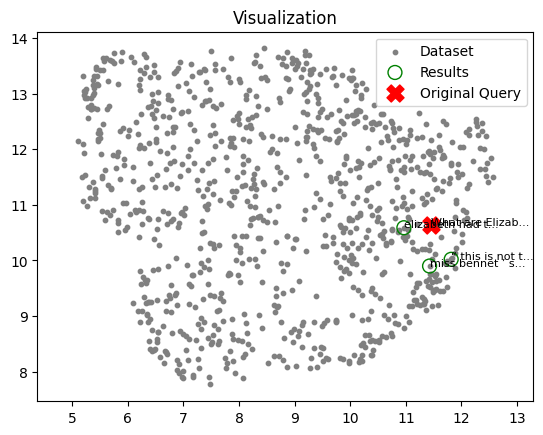

In [17]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'What are Elizabeth Bennet’s feelings toward Mr. Darcy after his first proposal at Hunsford?'  


plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


In [18]:
import numpy as np
from sklearn.metrics import pairwise_distances

# 2D-Koordinaten aus der UMAP-Projektion
center = np.mean(projected_dataset_embeddings, axis=0)
distances_to_center = np.linalg.norm(projected_dataset_embeddings - center, axis=1)

# Top-N Ausreißer anzeigen
n = 3
outlier_indices = distances_to_center.argsort()[::-1][:n]

for idx in outlier_indices:
    print(f"\nOutlier {idx} – Abstand: {distances_to_center[idx]:.2f}")
    print(token_split_texts[idx][:500])  # nur ersten 500 Zeichen anzeigen



Outlier 405 – Abstand: 4.19
charlotte and miss de bourgh - - the former of whom was engaged in listening to lady catherine, and the latter said not a word to her all the dinnertime. mrs. jenkinson was chiefly employed in watching how little miss de bourgh ate, pressing her to try some other dish and fearing she was indisposed. maria thought speaking out of the question, and the gentlemen did nothing but eat and admire.

Outlier 536 – Abstand: 4.10
at length the chaise arrived, the trunks were fastened on, the parcels placed within, and it was pronounced to be ready. after an affectionate parting between the friends, elizabeth was attended to the carriage by mr. collins ; and as they walked down the garden, he was commissioning her with his best respects to all her family, not forgetting his thanks for the kindness he had received at longbourn in the winter, and his compliments to mr. and mrs. gardiner, though unknown. he then handed her i

Outlier 417 – Abstand: 4.10
the dining parlou

---

## RAG baby

In [19]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

In [20]:
def build_prompt(context_chunks, user_query):
    context_block = "\n\n".join(context_chunks) #gegen hallucinations -->
    prompt = f"""You are a literary assistant specialized in Jane Austen's Pride and Prejudice.
Use only the information from the provided context to answer the question. 
Do not rely on prior knowledge. Do not guess.
Context:
{context_block}

Question:
{user_query}

Answer:"""
    return prompt


In [21]:
# 1. Lade API Key und mit prompt mal
from dotenv import load_dotenv
import os
from groq import Groq

load_dotenv(dotenv_path="env/.env")
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    raise ValueError("API Key not found! Please check your .env file.")

client = Groq(api_key=groq_api_key)


# 2. User query
user_query = "How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?"

# 3. Retrieve similar chunks
retrieved_chunks, retrieved_embeddings, retrieved_scores = retrieve_improved(user_query, top_k=5, search_k=100)

# 4. Build prompt
prompt = build_prompt(retrieved_chunks, user_query)

# 5. Groq Request
response = client.chat.completions.create(
    model="llama3-70b-8192",  # oder llama3-8b-8192 wenn kleiner llama3-70b-8192
    messages=[
        {"role": "system", "content": "You are a literary assistant."},
        {"role": "user", "content": prompt}
    ]
)

# 6. Ausgabe
print(prompt)
print(response.choices[0].message.content)





You are a literary assistant specialized in Jane Austen's Pride and Prejudice.
Use only the information from the provided context to answer the question. 
Do not rely on prior knowledge. Do not guess.
Context:
elizabeth felt herself growing more angry every moment ; yet she tried to the utmost to speak with composure when she said, - - “ you are mistaken, mr. darcy, if you suppose that the mode of your declaration affected me in any other way than as it spared me the concern which i might have felt in refusing you, had you behaved in a more gentlemanlike manner. ” she saw him start at this ; but he said nothing, and she continued, - - “ you could not have made me the offer of your hand in any possible way that would have tempted me to accept it. ” again his astonishment was obvious ; and he looked at her with an expression of mingled incredulity and mortification. she went on, - -

“ yours, etc. ” this letter gave elizabeth some pain ; but her spirits returned, as she considered that j

## Rewriting Querries --> ausprobiert und schlussendlich nicht eingesetzt (aber sie würden funktionieren; führt zu hallucinations tho)

In [22]:
def rewrite_query_strategy_1(original_query):
    system_instruction = """
Rewrite vague literary questions into precise, searchable queries. 
Add relevant context (characters, themes, plot elements) for better document retrieval.
Max 40 tokens. Return only the rewritten question.
Examples:
- "What about Hamlet?" → "How does Hamlet's indecision affect the play's tragic outcome?"
- "Love in the novel?" → "How does romantic love influence character development in the narrative?"
"""
    
    response = client.chat.completions.create(
    model="llama3-70b-8192", 

        messages=[
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": original_query}
        ]
    )
    
    return response.choices[0].message.content.strip()



In [23]:
def rewrite_query_strategy_2(original_query):
    system_instruction = """
    Rewrite vague literary questions (for pride and prejudice) into precise, searchable queries. 
    Add relevant context (characters, themes, plot elements) to capture the full narrative arc when asking about relationships or character development.
    For present-tense questions about feelings/relationships, expand to include evolution over time.
    
    Examples:
    "How does X feel about Y?" → "How do X's feelings toward Y change throughout the story?"
    "What does X think of Y?" → "How does X's opinion of Y develop from beginning to end?"
    "Is X happy?" → "How does X's emotional state evolve in the narrative?"
    
    Max 40 tokens. Return only the rewritten question. 
    Use only the provided context. If the original question cannot be accurately answered using only local scene-based information, rewrite it conservatively to match the scope. Do not assume full knowledge of the entire book.
    """
    
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": original_query}
        ]
    )
    
    return response.choices[0].message.content.strip()



### Update: Nach Ausprobieren irgendwie erkannt, dass es mit rewritten querries zum teil falsche Antworten gibt (zu globale) wenn es um spezifische momente geht, darum mal das weggetan und dann festgestellt, dass es zum teil sehr schlechte antworten gibt mit user query only. 

Der relevante Text über den Meryton Ball (z. B. Darcys Beleidigung) ist im Index vorhanden, aber wird beim Retrieval nicht gefunden.

Man fragt:
"What happens at the Meryton Ball?"
Aber: Die Antwort, die dein System zurückgibt, ist falsch:
"The text does not explicitly describe the Meryton Ball..."

## Simple Expansion

In [24]:
def simple_expansion(query):
    expansions = {
        "first proposal": ["Hunsford"],
        "second ball": ["Netherfield Ball", "Bingley", "Darcy", "assembly"],
        "Meryton": ["Meryton Assembly", "Meryton Ball", "first ball", "ball"],
        "feelings": ["emotions", "feelings", "change of heart", "opinion", "sentiments"],
        "engagement": ["marriage", "wedding"],
        "Wickham": ["scandal", "Lydia", "elopement", "reputation"],
        "first ball": ["Meryton Assembly", "Meryton Ball"],
        "second ball": ["Netherfield Ball", "assembly"],
    }
    for key, terms in expansions.items():
        if key.lower() in query.lower():
            query += " " + " ".join(terms)
    return query

user_query = "How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?"

expanded_query = simple_expansion(user_query)

retrieved_chunks, retrieved_embeddings, retrieved_scores = retrieve_improved(expanded_query, top_k=5, search_k=100)

prompt = build_prompt(retrieved_chunks, user_query)

response = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[
        {"role": "system", "content": "You are a literary assistant."},
        {"role": "user", "content": prompt}
    ]
)

print(prompt)
print(response.choices[0].message.content)



You are a literary assistant specialized in Jane Austen's Pride and Prejudice.
Use only the information from the provided context to answer the question. 
Do not rely on prior knowledge. Do not guess.
Context:
elizabeth felt herself growing more angry every moment ; yet she tried to the utmost to speak with composure when she said, - - “ you are mistaken, mr. darcy, if you suppose that the mode of your declaration affected me in any other way than as it spared me the concern which i might have felt in refusing you, had you behaved in a more gentlemanlike manner. ” she saw him start at this ; but he said nothing, and she continued, - - “ you could not have made me the offer of your hand in any possible way that would have tempted me to accept it. ” again his astonishment was obvious ; and he looked at her with an expression of mingled incredulity and mortification. she went on, - -

mr. darcy ’ s letter she was in a fair way of soon knowing by heart. she studied every sentence ; and her

## LLM Expansion

In [25]:
# Erweiterung: LLM Expansion
def expand_query_llm(user_query):
    expansion_prompt = f"""
You are an intelligent assistant specialized in semantic search.
Generate 3 alternative but semantically related queries for the following question:

Original query: "{user_query}"
"""
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[{"role": "user", "content": expansion_prompt}]
    )
    return [q.strip("- ").strip() for q in response.choices[0].message.content.split("\n") if q.strip()]


user_query = "How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?"

expanded_llm_queries = expand_query_llm(user_query)

all_llm_results = []
for expanded_query in expanded_llm_queries:
    chunks, _, _ = retrieve_improved(expanded_query, top_k=3, search_k=100)
    all_llm_results.extend(chunks)

final_chunks = list(dict.fromkeys(all_llm_results))[:5]

prompt = build_prompt(final_chunks, user_query)

response = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[
        {"role": "system", "content": "You are a literary assistant with focus on pride and prejudice."},
        {"role": "user", "content": prompt}
    ]
)
print(prompt)
print(response.choices[0].message.content)



You are a literary assistant specialized in Jane Austen's Pride and Prejudice.
Use only the information from the provided context to answer the question. 
Do not rely on prior knowledge. Do not guess.
Context:
elizabeth was pleased to find his memory so exact ; and he afterwards took occasion to ask her, when unattended to by any of the rest, whether _ all _ her sisters were at longbourn. there was not much in the question, nor in the preceding remark ; but there was a look and a manner which gave them meaning.

effectually to what they related? mr. darcy, who never looks at any woman but to see a blemish, and who probably never looked at _ you _ in his life! it is admirable! ”

mr. bingley and jane remained at netherfield only a twelvemonth. so near a vicinity to her mother and meryton relations was not desirable even to _ his _ easy temper, or _ her _ affectionate heart. the darling wish of his sisters was then gratified : he bought an estate in a neighbouring county to derbyshire ; 

## Antwortenbewertung (TEST) mit ChatGPT --> nicht implementiert

{
  "accuracy": 1–5,
  "depth": 1–5,
  "context_fit": 1–5,
  "hallucination": true/false,
  "final_comment": "Clear, insightful, on point."
}

Ich habe es versucht mit "coden" zu machen, aber min nicht mit der Antwort zufrieden... also es genügt mir irgendwie, wie nicht. Daher habe ich mich dazu entschieden dies manuell zu tun. --> https://chatgpt.com/share/68384b0b-934c-8004-b528-e4957b5e3656

In [26]:
# from openai import OpenAI
# import os, json
# from dotenv import load_dotenv

# load_dotenv("env/.env")
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# def evaluate_three_answers(question, baseline, rewrite1, rewrite2):
#     prompt = f"""
#     ...
#     """
#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         messages=[
#             {"role": "system", "content": "Du bist ein Experte für literarische Bewertung."},
#             {"role": "user", "content": prompt}
#         ],
#         temperature=0.1
#     )
#     return response.choices[0].message.content

# with open("data/evaluations_all_strategies.json", "r", encoding="utf-8") as f:
#     questions_data = json.load(f)

# results = {}

# for question, versions in questions_data.items():
#     print(f"\n🔍 Evaluating: {question[:60]}")

#     baseline = versions["baseline"]["answer"]
#     rewrite1 = versions["rewrite1"]["answer"]
#     rewrite2 = versions["rewrite2"]["answer"]

#     try:
#         eval_json_str = evaluate_three_answers(question, baseline, rewrite1, rewrite2)
#         eval_result = json.loads(eval_json_str)

#         results[question] = {
#             "evaluation": eval_result,
#             "answers": versions
#         }

#         print(f"✅ Beste Antwort: #{eval_result['best']}")
#         print(f"Scores: {eval_result['total_scores']}")

#     except json.JSONDecodeError:
#         print(f"❌ JSON-Fehler bei Frage: {question}")
#         print(eval_json_str)
#     except Exception as e:
#         print(f"❌ Fehler: {e}")


# Tests

In [27]:
query = "How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?"  
expanded_query = simple_expansion(query)
query_embedding = model.encode([expanded_query], convert_to_numpy=True)
distances, indices = index.search(query_embedding, k=10)

for i, idx in enumerate(indices[0]):
    print(f"Score: {distances[0][i]}")
    print(f"Chunk {i}:\n{token_split_texts[idx][:30]}")


Score: 0.5400652289390564
Chunk 0:
elizabeth felt herself growing
Score: 0.5716787576675415
Chunk 1:
mr. darcy ’ s letter she was i
Score: 0.5734914541244507
Chunk 2:
“ yours, etc. ” this letter ga
Score: 0.5804449915885925
Chunk 3:
elizabeth, when mr. darcy gave
Score: 0.5831201076507568
Chunk 4:
and habitual study to decide o
Score: 0.5874998569488525
Chunk 5:
mr. darcy, who was leaning aga
Score: 0.5941898822784424
Chunk 6:
“ oh, yes! be so kind as to ap
Score: 0.6053377985954285
Chunk 7:
miss bennet ’ s astonishment w
Score: 0.6111084818840027
Chunk 8:
“ i should not be surprised, ”
Score: 0.6139479875564575
Chunk 9:
elizabeth, still more affected


In [28]:
# Test-Fragen

all_results = {}

questions = [
    "How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?",
    "What are Elizabeth Bennet’s feelings toward Mr. Darcy after his first proposal at Hunsford?",
    "how does Lizzy feel about Darcy?",
    "What is Elisabeth's first impression on Mr. Darcy?",
    "What character appears for the first time during the second ball?"
]

for question in questions:
    print("\n" + "="*80)
    print(f"Original Question: {question}")

    #### 1. BASELINE ####
    chunks, _, _ = retrieve_improved(question, top_k=5, search_k=100)
    prompt = build_prompt(chunks, question)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a literary assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    print("\n🔵 BASELINE ANSWER:")
    print(response.choices[0].message.content)

    #### 2. REWRITE 1 ####
    rewritten_q1 = rewrite_query_strategy_1(question)
    chunks, _, _ = retrieve_improved(rewritten_q1, top_k=5, search_k=100)
    prompt = build_prompt(chunks, question)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a literary assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    print("\n🟣 REWRITE 1 ANSWER:")
    print(response.choices[0].message.content)

    #### 3. REWRITE 2 ####
    rewritten_q2 = rewrite_query_strategy_2(question)
    chunks, _, _ = retrieve_improved(rewritten_q2, top_k=5, search_k=100)
    prompt = build_prompt(chunks, question)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a literary assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    print("\n🟠 REWRITE 2 ANSWER:")
    print(response.choices[0].message.content)

    #### 4. MANUAL EXPANSION ####
    expanded_q = simple_expansion(question)
    chunks, _, _ = retrieve_improved(expanded_q, top_k=5, search_k=100)
    prompt = build_prompt(chunks, question)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a literary assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    print("\n🟢 MANUAL EXPANSION ANSWER:")
    print(response.choices[0].message.content)

    #### 5. LLM EXPANSION ####
    llm_expansions = expand_query_llm(question)
    all_chunks = []
    for eq in llm_expansions:
        chunks, _, _ = retrieve_improved(eq, top_k=3, search_k=100)
        all_chunks.extend(chunks)
    final_chunks = list(dict.fromkeys(all_chunks))[:5]
    prompt = build_prompt(final_chunks, question)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a literary assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    print("\n🟡 LLM EXPANSION ANSWER:")
    print(response.choices[0].message.content)


# Nach der ganzen Schleife: Ergebnisse als JSON speichern
with open("evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)



Original Question: How does Elizabeth react to the letter Darcy gives her after rejecting his first proposal?

🔵 BASELINE ANSWER:
According to the context, Elizabeth does not expect the letter to contain a renewal of Darcy's offers, and she has formed no expectation at all of its contents. However, when she reads the letter, she goes through it eagerly and experiences a contrariety of feelings that are scarcely to be defined.

🟣 REWRITE 1 ANSWER:
Elizabeth reacts to the letter with a mix of emotions. Initially, she is amazed that Darcy believes he has an apology to make, and she is persuaded that he has no explanation that would not be concealed by shame. She reads the letter with eagerness, impatience, and strong prejudice against what Darcy might say. As she reads, her feelings change, and she experiences contrariety (opposite emotions). At times, she feels indignation, but then her anger turns against herself, and she develops compassion for Darcy's disappointed feelings. She also 

In [29]:
def rag_answer(user_query):

    expanded_query = simple_expansion(user_query)

    retrieved_chunks, retrieved_embeddings, retrieved_scores = retrieve_improved(expanded_query, top_k=5, search_k=100)

    prompt = build_prompt(retrieved_chunks, user_query)

    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": "You are a helpful literary assistant with expertise in Pride and Prejudice."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()


## Gradio

In [30]:
import gradio as gr

gr.Interface(
    fn=rag_answer,
    inputs=gr.Textbox(lines=2, placeholder="Ask about Pride & Prejudice…"),
    outputs="text",
    title="P&P RAG Demo",
    description="Retrieval-Augmented Q&A über Austen's Roman"
).launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
